# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder

# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# Load the dataset from your Drive folder

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
x_train = train['X']
y_train = train['y']
x_train = x_train.astype('float64')
y_train = y_train.astype('int64')

x_test = test['X']
x_test = x_test.astype('float64')
y_test = test['y']
y_test = y_test.astype('int64')

# reorder data
x_train = np.moveaxis(x_train, -1, 0)
x_test = np.moveaxis(x_test, -1, 0)

In [5]:
print('Min: {}, Max: {}'.format(x_train.min(), x_train.max()))

Min: 0.0, Max: 255.0


In [6]:
def normalize_data(x):
    '''
    normalize data so that values are between 0 to 1
    '''
    x = x / 255.0
    return x

x_train = normalize_data(x_train)
x_test = normalize_data(x_test)

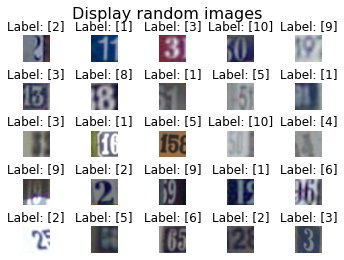

In [7]:
import matplotlib.pyplot as plt

# this code displays 5x5 random images in gray scale

n_width = 5
n_height = 5
fig, ax = plt.subplots(nrows=n_height, ncols=n_width)
fig.subplots_adjust(hspace=0.8, wspace=0.1)
fig.suptitle('Display random images', fontsize=16)
flattened_ax = ax.flatten()
for i in flattened_ax:
    rand_idx = np.random.randint(x_train.shape[0])
    i.set_axis_off()
    i.imshow(x_train[rand_idx, :, :, :])
    i.title.set_text("Label: " + str(y_train[rand_idx]))

In [8]:
def colored_to_gray(x):
    '''
    input shape: n_sample, n_x, x_y, n_channel
    output shape: n_sample, n_x, x_y, 1
    this is a rudementary way of converting a colored image into gray image
    '''
    x = np.mean(x, axis=-1, keepdims=True)
    return x

x_train = colored_to_gray(x_train)
x_test = colored_to_gray(x_test)

print("Shape of Training Data: {}".format(x_train.shape))
print("Shape of Training Labels: {}".format(y_train.shape))
print("Shape of Testing Data: {}".format(x_test.shape))
print("Shape of Testing Labels: {}".format(y_test.shape))

Shape of Training Data: (73257, 32, 32, 1)
Shape of Training Labels: (73257, 1)
Shape of Testing Data: (26032, 32, 32, 1)
Shape of Testing Labels: (26032, 1)


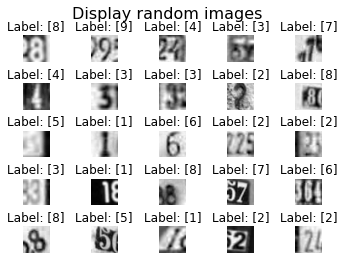

In [9]:
# this code displays 5x5 random images in gray scale

n_width = 5
n_height = 5
fig, ax = plt.subplots(nrows=n_height, ncols=n_width)
fig.subplots_adjust(hspace=0.8, wspace=0.1)
fig.suptitle('Display random images', fontsize=16)
flattened_ax = ax.flatten()
for i in flattened_ax:
    rand_idx = np.random.randint(x_train.shape[0])
    i.set_axis_off()
    i.imshow(x_train[rand_idx, :, :], cmap='gray')
    i.title.set_text("Label: " + str(y_train[rand_idx]))

In [10]:
print('Min: {}, Max: {}'.format(x_train.min(), x_train.max()))

Min: 0.0, Max: 1.0


### One hot encoder
Convert training and test labels to one hot encoded matrix

In [11]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [13]:
def lr_function(epoch, lr):
    if (epoch) % 10 == 0:
        return lr/5
    else:
        return lr

model_dnn = Sequential([
    Flatten(name='Flatten_Input', input_shape=x_train.shape[1:]),
    Dense(units=2048, activation='relu', name='Dense_1'),
    Dense(units=1024, activation='relu', name='Dense_2'),
    Dense(units=512, activation='relu', name='Dense_3'),
    Dense(units=10, activation='softmax', name='Output')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.005)

model_dnn.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten_Input (Flatten)      (None, 1024)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
Dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
Dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
Output (Dense)               (None, 10)                5130      
Total params: 4,727,306
Trainable params: 4,727,306
Non-trainable params: 0
_________________________________________________________________


In [15]:
callback_list = [
    tf.keras.callbacks.LearningRateScheduler(lr_function, verbose=1), 
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints_best_only_DNN\checkpoint',
                                       save_weights_only=True,
                                       monitor='val_accuracy',
                                       save_best_only=True)
]

history_dnn = model_dnn.fit(x_train, y_train, epochs=50,
                    validation_split = 0.15,
                    batch_size=256,
                    shuffle=True, 
                    callbacks=callback_list)

Train on 62268 samples, validate on 10989 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0009999999776482583.
Epoch 1/50
62268/62268 [==============================] - 2s 31us/sample - loss: 2.2111 - accuracy: 0.2028 - val_loss: 1.9165 - val_accuracy: 0.3196

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
Epoch 2/50
62268/62268 [==============================] - 1s 20us/sample - loss: 1.5802 - accuracy: 0.4545 - val_loss: 1.3337 - val_accuracy: 0.5609

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
Epoch 3/50
62268/62268 [==============================] - 1s 20us/sample - loss: 1.2392 - accuracy: 0.5955 - val_loss: 1.2227 - val_accuracy: 0.5938

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
Epoch 4/50
62268/62268 [==============================] - 1s 19us/sample - loss: 1.1067 - accuracy: 0.6442 - val_loss: 1.1556 - val_accuracy: 0.6309

Epoch 00005: 

62268/62268 [==============================] - 1s 18us/sample - loss: 0.5103 - accuracy: 0.8412 - val_loss: 0.6217 - val_accuracy: 0.8074


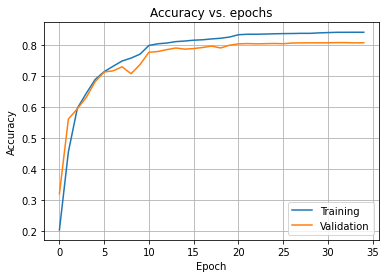

In [16]:
plt.plot(history_dnn.history['accuracy'])
plt.plot(history_dnn.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.grid()
plt.show() 

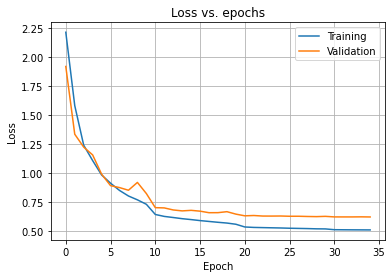

In [17]:
plt.plot(history_dnn.history['loss'])
plt.plot(history_dnn.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid()
plt.show()

In [18]:
test_loss, test_acc = model_dnn.evaluate(x_test, y_test, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.711
Test accuracy: 78.78%


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [19]:
model_cnn = Sequential([
    tf.keras.layers.Conv2D(input_shape=x_train.shape[1:], activation='relu', filters=32, kernel_size=(3,3), padding='same', name='Conv_1'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), name='Pool_1'),
    tf.keras.layers.BatchNormalization(name='Batch_Norm_1'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu', name='Conv_2'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), name='Pool_2'),    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='Conv_3'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), name='Pool_3'),
    tf.keras.layers.Flatten(name='Flatten'),
    tf.keras.layers.Dense(units=256, activation='relu', name='Dense_1'),
    tf.keras.layers.Dropout(rate=0.5, name='Dropout_1'),
    tf.keras.layers.Dense(units=10, activation='softmax', name='Output'),
])

opt = tf.keras.optimizers.Adam(learning_rate=0.005)

model_cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 16, 16, 32)        0         
_________________________________________________________________
Batch_Norm_1 (BatchNormaliza (None, 16, 16, 32)        128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 14, 14, 32)        9248      
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 7, 7, 32)          0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 5, 5, 16)          4624      
_________________________________________________________________
Pool_3 (MaxPooling2D)        (None, 2, 2, 16)         

In [21]:
def lr_function_cnn(epoch, lr):
    if (epoch) % 15 == 0:
        return lr/5
    else:
        return lr
    
callback_list = [
    tf.keras.callbacks.LearningRateScheduler(lr_function_cnn, verbose=1), 
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints_best_only_CNN\checkpoint',
                                       save_weights_only=True,
                                       monitor='val_accuracy',
                                       save_best_only=True)
]

history_cnn = model_cnn.fit(x_train, y_train, epochs=50,
                    validation_split = 0.15,
                    batch_size=128,
                    shuffle=True, 
                    callbacks=callback_list)

Train on 62268 samples, validate on 10989 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0009999999776482583.
Epoch 1/50
62268/62268 [==============================] - 4s 69us/sample - loss: 1.1277 - accuracy: 0.6303 - val_loss: 0.8595 - val_accuracy: 0.8015

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
Epoch 2/50
62268/62268 [==============================] - 2s 36us/sample - loss: 0.6241 - accuracy: 0.8120 - val_loss: 0.6251 - val_accuracy: 0.8103

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
Epoch 3/50
62268/62268 [==============================] - 2s 36us/sample - loss: 0.5337 - accuracy: 0.8401 - val_loss: 0.5291 - val_accuracy: 0.8332

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
Epoch 4/50
62268/62268 [==============================] - 2s 36us/sample - loss: 0.4862 - accuracy: 0.8536 - val_loss: 0.4588 - val_accuracy: 0.8608

Epoch 00005: 

62268/62268 [==============================] - 2s 36us/sample - loss: 0.2620 - accuracy: 0.9223 - val_loss: 0.3341 - val_accuracy: 0.9054

Epoch 00036: LearningRateScheduler reducing learning rate to 3.99999953515362e-05.
Epoch 36/50
62268/62268 [==============================] - 2s 36us/sample - loss: 0.2602 - accuracy: 0.9220 - val_loss: 0.3354 - val_accuracy: 0.9060

Epoch 00037: LearningRateScheduler reducing learning rate to 3.99999953515362e-05.
Epoch 37/50
62268/62268 [==============================] - 2s 36us/sample - loss: 0.2606 - accuracy: 0.9222 - val_loss: 0.3367 - val_accuracy: 0.9055

Epoch 00038: LearningRateScheduler reducing learning rate to 3.99999953515362e-05.
Epoch 38/50
62268/62268 [==============================] - 2s 36us/sample - loss: 0.2599 - accuracy: 0.9225 - val_loss: 0.3352 - val_accuracy: 0.9052

Epoch 00039: LearningRateScheduler reducing learning rate to 3.99999953515362e-05.
Epoch 39/50
62268/62268 [==============================] - 2s 36us/sample - 

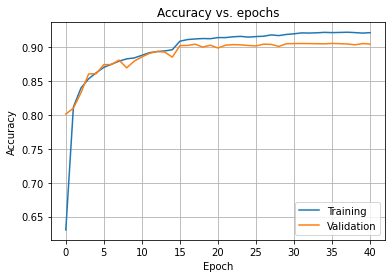

In [22]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.grid()
plt.show() 

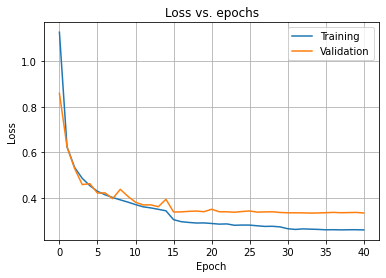

In [23]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid()
plt.show()

In [24]:
test_loss, test_acc = model_cnn.evaluate(x_test, y_test, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.359
Test accuracy: 90.06%


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [25]:
model_dnn.load_weights('checkpoints_best_only_DNN/checkpoint')
model_cnn.load_weights('checkpoints_best_only_CNN/checkpoint')

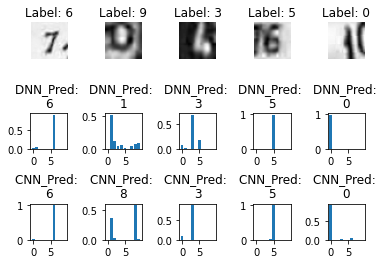

In [26]:
n_width = 5
n_height = 3
fig, ax = plt.subplots(nrows=n_height, ncols=n_width)
fig.subplots_adjust(hspace=1.5, wspace=1)
flattened_ax = ax.flatten()
for i in range(0, n_width):
    rand_idx = np.random.randint(x_test.shape[0])
    flattened_ax[i].set_axis_off()
    flattened_ax[i].imshow(x_test[rand_idx, :, :], cmap='gray')
    flattened_ax[i].title.set_text("Label: " + str(np.argmax(y_test[rand_idx])))
    
    pred_image = x_test[rand_idx, :, :, :]
    pred_image = pred_image[np.newaxis, ...]
    
    pred_dnn = model_dnn.predict(pred_image)    
    pred_cnn = model_cnn.predict(pred_image)    
    
    flattened_ax[i+n_width].bar(range(0, 10), np.squeeze(pred_dnn))
    flattened_ax[i+n_width].title.set_text("DNN_Pred: \n" + str(np.argmax(np.squeeze(pred_dnn))))
    flattened_ax[i+2*n_width].bar(range(0, 10), np.squeeze(pred_cnn))
    flattened_ax[i+2*n_width].title.set_text("CNN_Pred: \n" + str(np.argmax(np.squeeze(pred_cnn))))
    